# Assignment 5: Classification Showdown

Build and compare classification models on the Fashion-MNIST dataset.

## Setup

In [1]:
import os
import json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
)
from xgboost import XGBClassifier

from helpers import load_fashion_mnist, plot_roc_curves, plot_confusion_matrix

# Create output directory
OUTPUT_DIR = "output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Setup complete!")

Setup complete!


---

## Part 1: Binary Classification

**Task:** Classify T-shirts (label 0) vs Trousers (label 1)

This is a straightforward binary classification task. Focus on:
- Filtering data to the target classes
- Proper train/test splitting with stratification
- Scaling features correctly (fit on train only!)

In [2]:
# Explore the dataset
print("Loading dataset...")
X, y = load_fashion_mnist()
print(f"Dataset loaded with {X.shape[0]} samples and {X.shape[1]} features.")
print(f"Number of classes: {len(np.unique(y))}")
print(f"Class distribution: {np.bincount(y)}")

Loading dataset...
Dataset loaded with 70000 samples and 784 features.
Number of classes: 10
Class distribution: [7000 7000 7000 7000 7000 7000 7000 7000 7000 7000]


In [3]:
print("Part 1: Binary Classification")
print("-" * 40)

# Load the full dataset
X, y = load_fashion_mnist()

# Filter to only labels 0 and 1
# Hint: np.isin(y, [0, 1]) returns a boolean array where True means the label is 0 or 1
# Use this mask to index into X and y: X[mask], y[mask]
mask = np.isin(y, [0, 1])  # TODO: create boolean mask for labels 0 and 1
X_filtered = X[mask]  # TODO: apply mask to X
y_filtered = y[mask]  # TODO: apply mask to y

print("X_filtered shape:", X_filtered.shape)
print("y_filtered shape:", y_filtered.shape)
print("Unique labels:", np.unique(y_filtered))


Part 1: Binary Classification
----------------------------------------
X_filtered shape: (14000, 784)
y_filtered shape: (14000,)
Unique labels: [0 1]


In [4]:
print("First 10 labels:", y_filtered[:10])

First 10 labels: [0 0 0 0 1 0 1 0 0 1]


In [5]:
print("First image raw pixels:\n", X_filtered[0])

First image raw pixels:
 [  0.   0.   0.   0.   0.   1.   0.   0.   0.   0.  41. 188. 103.  54.
  48.  43.  87. 168. 133.  16.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   1.   0.   0.   0.  49. 136. 219. 216. 228. 236. 255.
 255. 255. 255. 217. 215. 254. 231. 160.  45.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.  14. 176. 222. 224. 212. 203. 198. 196. 200.
 215. 204. 202. 201. 201. 201. 209. 218. 224. 164.   0.   0.   0.   0.
   0.   0.   0.   0.   0. 188. 219. 200. 198. 202. 198. 199. 199. 201.
 196. 198. 198. 200. 200. 200. 200. 201. 200. 225.  41.   0.   0.   0.
   0.   0.   0.   0.  51. 219. 199. 203. 203. 212. 238. 248. 250. 245.
 249. 246. 247. 252. 248. 235. 207. 203. 203. 222. 140.   0.   0.   0.
   0.   0.   0.   0. 116. 226. 206. 204. 207. 204. 101.  75.  47.  73.
  48.  50.  45.  51.  63. 113. 222. 202. 206. 220. 224.   0.   0.   0.
   0.   0.   0.   0. 200. 222. 209. 203. 215. 200.   0.  70.  98.   0.
 103.  59.  68.  71.  49.   0. 219. 206. 214. 210. 2

In [6]:
img = X_filtered[0].reshape(28, 28)
print(img)

[[  0.   0.   0.   0.   0.   1.   0.   0.   0.   0.  41. 188. 103.  54.
   48.  43.  87. 168. 133.  16.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   1.   0.   0.   0.  49. 136. 219. 216. 228. 236. 255.
  255. 255. 255. 217. 215. 254. 231. 160.  45.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.  14. 176. 222. 224. 212. 203. 198. 196. 200.
  215. 204. 202. 201. 201. 201. 209. 218. 224. 164.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0. 188. 219. 200. 198. 202. 198. 199. 199. 201.
  196. 198. 198. 200. 200. 200. 200. 201. 200. 225.  41.   0.   0.   0.]
 [  0.   0.   0.   0.  51. 219. 199. 203. 203. 212. 238. 248. 250. 245.
  249. 246. 247. 252. 248. 235. 207. 203. 203. 222. 140.   0.   0.   0.]
 [  0.   0.   0.   0. 116. 226. 206. 204. 207. 204. 101.  75.  47.  73.
   48.  50.  45.  51.  63. 113. 222. 202. 206. 220. 224.   0.   0.   0.]
 [  0.   0.   0.   0. 200. 222. 209. 203. 215. 200.   0.  70.  98.   0.
  103.  59.  68.  71.  49.   0. 219. 206. 214. 210. 250.  

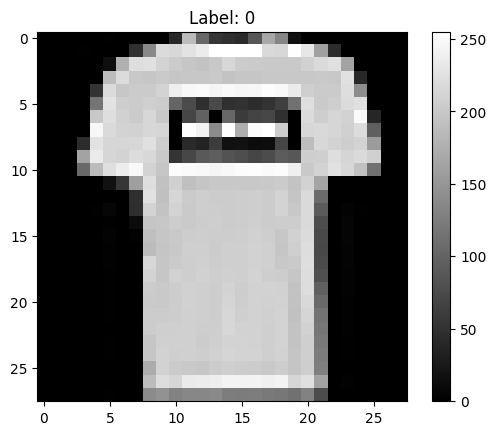

In [7]:
import matplotlib.pyplot as plt

plt.imshow(img, cmap="gray")
plt.title(f"Label: {y_filtered[0]}")
plt.colorbar()
plt.show()

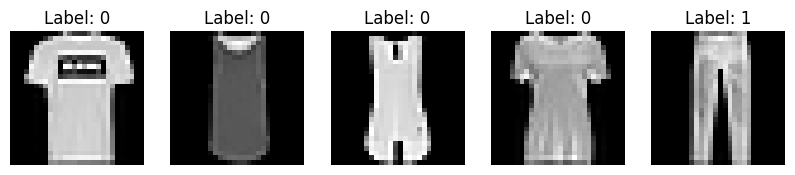

In [8]:
fig, axes = plt.subplots(1, 5, figsize=(10, 3))

for i, ax in enumerate(axes):
    img = X_filtered[i].reshape(28, 28)
    ax.imshow(img, cmap="gray")
    ax.set_title(f"Label: {y_filtered[i]}")
    ax.axis("off")

plt.show()


In [9]:

# Train/test split with stratification
# Use test_size=0.2, random_state=42, stratify=y_filtered
X_train, X_test, y_train, y_test = train_test_split(
    X_filtered,
    y_filtered,
    test_size=0.2,
    random_state=42,
    stratify=y_filtered
)  # TODO

# Scale features - fit on train, transform both
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # TODO: fit_transform on X_train
X_test_scaled = scaler.transform(X_test)   # TODO: transform X_test (not fit_transform!)

# Train LogisticRegression (use max_iter=1000, random_state=42)
model = LogisticRegression(max_iter=1000, random_state=42)  # TODO
model.fit(X_train_scaled, y_train)  # TODO: fit the model

# Evaluate
y_pred = model.predict(X_test_scaled)  # TODO: predict on X_test_scaled, 
#we are getting predicted probabilities, so we need to threshold them at 0.5 to get binary predictions
accuracy = accuracy_score(y_test, y_pred)  # TODO: calculate accuracy_score
cm = confusion_matrix(y_test, y_pred)  # TODO: calculate confusion_matrix

# Save results
results = {
    "task": "tshirt_vs_trouser",
    "accuracy": accuracy,
    "confusion_matrix": cm.tolist()  # Convert numpy array to list for JSON
}
with open(os.path.join(OUTPUT_DIR, "part1_results.json"), "w") as f:
    json.dump(results, f, indent=2)

print(f"Accuracy: {accuracy:.4f}")
print(f"Confusion Matrix:\n{cm}")

Accuracy: 0.9836
Confusion Matrix:
[[1371   29]
 [  17 1383]]


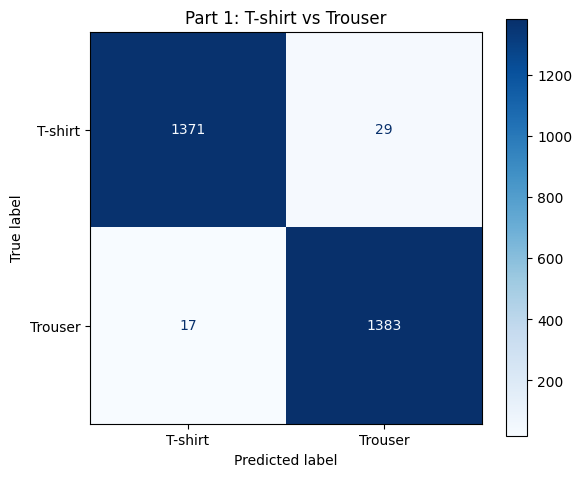

In [10]:
# Visualize results (provided - not part of assignment)
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(6, 5))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['T-shirt', 'Trouser']).plot(ax=ax, cmap='Blues')
ax.set_title('Part 1: T-shirt vs Trouser')
plt.tight_layout()
plt.show()

In [11]:
print("Before scaling:")
print("Mean of first feature:", X_train[:, 0].mean())
print("Std of first feature:", X_train[:, 0].std())

print("\nAfter scaling:")
print("Mean of first feature:", X_train_scaled[:, 0].mean())
print("Std of first feature:", X_train_scaled[:, 0].std())

Before scaling:
Mean of first feature: 0.0007142857
Std of first feature: 0.066811495

After scaling:
Mean of first feature: -1.0217939e-09
Std of first feature: 0.9999999


---

## Part 2: Multi-class Classification with Cross-Validation

**Task:** Classify footwear types: Sandal (5) vs Sneaker (7) vs Ankle boot (9)

Compare three models using 5-fold cross-validation. Select the best model and evaluate on test set.

**Required outputs:**
- `output/part2_cv_results.csv` - columns: `model`, `fold`, `score`
- `output/part2_test_results.csv` - classification report as DataFrame

In [12]:
print("\nPart 2: Multi-class Classification with CV")
print("-" * 40)

# TODO: Load data, filter to labels 5, 7, 9
X, y = load_fashion_mnist()
mask = np.isin(y, [5, 7, 9]) # A filter where we only keep samples with y labels 5, 7, or 9

# apply mask to X and y
X_filtered = X[mask]
y_filtered = y[mask]

# Print shapes and unique labels to verify
print("Filtered shapes:", X_filtered.shape, y_filtered.shape)
print("Original labels present:", np.unique(y_filtered))

# TODO: Encode labels to 0, 1, 2 using LabelEncoder (required for XGBoost)
le = LabelEncoder()
y_encoded = le.fit_transform(y_filtered)

print("Encoded labels present:", np.unique(y_encoded))
print("Label mapping (encoded -> original):")
for encoded_class, original_class in enumerate(le.classes_):
    print(f"  {encoded_class} -> {original_class}")

# TODO: Train/test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_filtered,
    y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

# TODO: Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Models to compare
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, verbosity=0, n_jobs=-1)
}

# TODO: Run 5-fold CV for each model (use StratifiedKFold, scoring='accuracy')

# TODO: Save CV results to part2_cv_results.csv

# TODO: Find best model by mean CV score
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rows = []
for model_name, model in models.items():
    fold_scores = cross_val_score(
        model,
        X_train_scaled,
        y_train,
        cv=cv,
        scoring="accuracy",
        n_jobs=-1
    )
    for fold_idx, s in enumerate(fold_scores, start=1):
        rows.append({"model": model_name, "fold": fold_idx, "score": float(s)})

part2_cv_df = pd.DataFrame(rows)
part2_cv_df.to_csv(os.path.join(OUTPUT_DIR, "part2_cv_results.csv"), index=False)

# best model by mean CV score (computed from fold rows)
best_model_name = (
    part2_cv_df.groupby("model")["score"].mean().sort_values(ascending=False).index[0]
)
best_model = models[best_model_name]

# TODO: Retrain best model on full training data
best_model.fit(X_train_scaled, y_train)

# TODO: Evaluate on test set, save classification_report to part2_test_results.csv
y_test_pred = best_model.predict(X_test_scaled)

report_dict = classification_report(y_test, y_test_pred, output_dict=True, zero_division=0)
report_df = pd.DataFrame(report_dict).transpose()

# Optional: replace encoded labels in rows 0/1/2 with original labels 5/7/9 (for readability)
# classification_report outputs class rows as strings like "0", "1", "2"
label_rename = {str(i): f"{i} (orig {le.inverse_transform([i])[0]})" for i in np.unique(y_train)}
report_df.rename(index=label_rename, inplace=True)

test_results_path = os.path.join(OUTPUT_DIR, "part2_test_results.csv")
report_df.to_csv(test_results_path)
print(f"Saved test classification report to: {test_results_path}")
print(report_df)


Part 2: Multi-class Classification with CV
----------------------------------------
Filtered shapes: (21000, 784) (21000,)
Original labels present: [5 7 9]
Encoded labels present: [0 1 2]
Label mapping (encoded -> original):
  0 -> 5
  1 -> 7
  2 -> 9
Saved test classification report to: output/part2_test_results.csv
              precision    recall  f1-score      support
0 (orig 5)     0.983465  0.977143  0.980294  1400.000000
1 (orig 7)     0.952113  0.965714  0.958865  1400.000000
2 (orig 9)     0.969042  0.961429  0.965221  1400.000000
accuracy       0.968095  0.968095  0.968095     0.968095
macro avg      0.968207  0.968095  0.968127  4200.000000
weighted avg   0.968207  0.968095  0.968127  4200.000000


cv_df not defined yet - complete the TODOs above first!


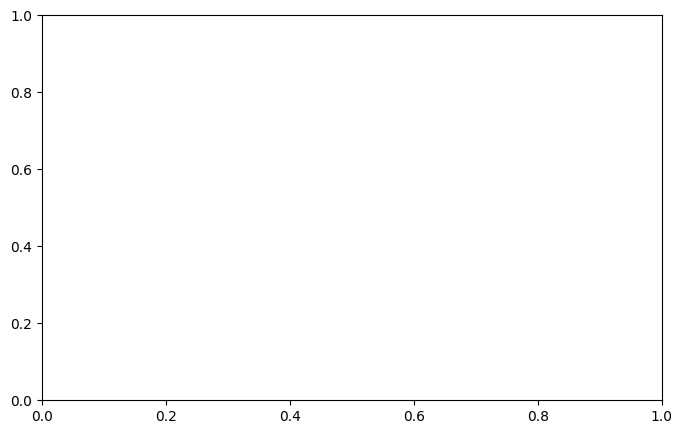

In [13]:
# Visualize CV results (provided - not part of assignment)
import matplotlib.pyplot as plt

try:
    fig, ax = plt.subplots(figsize=(8, 5))
    cv_results_df.boxplot(column='cv_mean_accuracy', by='model', ax=ax)
    ax.set_title('Part 2: Cross-Validation Scores by Model')
    ax.set_xlabel('Model')
    ax.set_ylabel('Accuracy')
    plt.suptitle('')  # Remove automatic title
    plt.tight_layout()
    plt.show()
except NameError:
    print("cv_df not defined yet - complete the TODOs above first!")

---

## Part 3: Full Model Comparison Pipeline

**Task:** Classify Clothing vs Footwear (binary)

- **Clothing (0):** T-shirt, Trouser, Pullover, Dress, Coat, Shirt (labels 0-4, 6)
- **Footwear (1):** Sandal, Sneaker, Ankle boot (labels 5, 7, 9)
- **Exclude:** Bag (label 8)

Compare 3 models using AUC, generate ROC curves, evaluate best model.

**Required outputs:**
- `output/part3_cv_results.csv` - columns: `model`, `fold`, `auc`
- `output/part3_test_results.csv` - columns: `model`, `accuracy`, `auc`
- `output/part3_roc_curves.png` - use `plot_roc_curves()` from helpers
- `output/part3_confusion_matrix.png` - use `plot_confusion_matrix()` from helpers

In [ ]:
print("\nPart 3: Full Model Comparison Pipeline")
print("-" * 40)

# TODO: Load data, filter out bags (label 8)
X, y = load_fashion_mnist()

mask_not_bag = y != 8
X_nb = X[mask_not_bag]
y_nb = y[mask_not_bag]

print("After removing bags:", X_nb.shape, y_nb.shape)
print("Labels present:", np.unique(y_nb))

# TODO: Create binary labels: footwear (5, 7, 9) = 1, clothing = 0
footwear_labels = [5, 7, 9]
y_binary = np.isin(y_nb, footwear_labels).astype(int)

print("Binary label counts (0=clothing, 1=footwear):", np.bincount(y_binary))

# TODO: Train/test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_nb,
    y_binary,
    test_size=0.2,
    random_state=42,
    stratify=y_binary
)

# TODO: Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Models to compare
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, verbosity=0, n_jobs=-1)
}

# TODO: Run 5-fold CV for all models (use StratifiedKFold, scoring='roc_auc')
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rows = []
for model_name, model in models.items():
    fold_aucs = cross_val_score(
        model,
        X_train_scaled,
        y_train,
        cv=cv,
        scoring="roc_auc",
        n_jobs=-1
    )
    for fold_idx, a in enumerate(fold_aucs, start=1):
        rows.append({"model": model_name, "fold": fold_idx, "auc": float(a)})

part3_cv_df = pd.DataFrame(rows)
part3_cv_df.to_csv(os.path.join(OUTPUT_DIR, "part3_cv_results.csv"), index=False)

# pick best by mean AUC
best_model_name = (
    part3_cv_df.groupby("model")["auc"].mean().sort_values(ascending=False).index[0]
)

print(f"\nBest model by mean CV AUC: {best_model_name}")

# TODO: Train ALL models on full training data (needed for ROC curves)
trained_models = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    trained_models[name] = model

# TODO: Generate ROC curves: plot_roc_curves(trained_models, X_test_scaled, y_test, save_path)
roc_path = os.path.join(OUTPUT_DIR, "part3_roc_curves.png")
plot_roc_curves(trained_models, X_test_scaled, y_test, save_path=roc_path)
print(f"Saved ROC curves to: {roc_path}")

# TODO: Evaluate best model on test set (accuracy and AUC)
best_model = trained_models[best_model_name]

# Predict class labels for confusion matrix + accuracy
y_pred = best_model.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_pred)

# Predict probabilities for AUC
y_proba = best_model.predict_proba(X_test_scaled)[:, 1]
test_auc = roc_auc_score(y_test, y_proba)

print(f"\nBest model test accuracy: {test_accuracy:.4f}")
print(f"Best model test AUC:      {test_auc:.4f}")

# TODO: Generate confusion matrix: plot_confusion_matrix(y_test, y_pred, ['Clothing', 'Footwear'], save_path)
cm_path = os.path.join(OUTPUT_DIR, "part3_confusion_matrix.png")
plot_confusion_matrix(y_test, y_pred, ['Clothing', 'Footwear'], save_path=cm_path)
print(f"Saved confusion matrix to: {cm_path}")



Part 3: Full Model Comparison Pipeline
----------------------------------------
After removing bags: (63000, 784) (63000,)
Labels present: [0 1 2 3 4 5 6 7 9]
Binary label counts (0=clothing, 1=footwear): [42000 21000]

Best model by mean CV AUC: XGBoost
Saved ROC curves to: output/part3_roc_curves.png

Best model test accuracy: 0.9994
Best model test AUC:      1.0000
Saved confusion matrix to: output/part3_confusion_matrix.png


NameError: name 'auc' is not defined

In [15]:

# TODO: Save test results to part3_test_results.csv
part3_test_df = pd.DataFrame([{
    "model": best_model_name,
    "accuracy": float(test_accuracy),
    "auc": float(test_auc)
}])
part3_test_df.to_csv(os.path.join(OUTPUT_DIR, "part3_test_results.csv"), index=False)

print(part3_test_df)


     model  accuracy       auc
0  XGBoost  0.999365  0.999996


---

## Validation

In [ ]:
# Run in terminal: pytest .github/tests/ -v
print("Run 'pytest .github/tests/ -v' in your terminal to check your work.")